This is the notebook for converting the model file to moog format and other things.

In [1]:
import pymoog
from astropy import constants
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.spatial import Delaunay
import os
import pickle

%matplotlib inline

# MARCS grid 

In [661]:
# Here we calculate the Delaunay triangulation for MRACS models, and sotre them into corredponding folders.
def save_marcs_delaunay(folder_path, tri_columns=['teff', 'g', '[M/H]', 'vmicro', 'mass']):
    '''
    Generate the DataFrame of grid points and Delaunay triangulation for MARCS models, and save it to the same folder. For internal use.
    
    Parameters
    ----------
    folder_path : str
        The folder path for generating the grid points DataFrame and Delaunay triangulation.
    tri_columns : list
        List of columns to be used for Delaunay triangulation.
    '''
    marcs_name_list = os.listdir(folder_path)
    marcs_name_list = [i for i in marcs_name_list if 'mod' in i]
    marcs_grid = []

    for model in marcs_name_list:
        marcs_grid.append(list(marcs_filename2gridpoint(model).values()))

    marcs_grid = pd.DataFrame(marcs_grid, columns=['chem', 'geo', 'teff', 'logg', 'mass', 'vmicro', '[M/H]', '[alpha/Fe]', 
                                                           '[C/Fe]', '[N/Fe]', '[O/Fe]', 'r', 's'])    
    marcs_grid['g'] = 10**marcs_grid['logg']
    
    # Sanity check: chem and geo have to be the same in the dataframe.
    if len(marcs_st_p_grid.groupby(['chem', 'geo']).size()) > 1:
        raise ValueError('Chemical composition or model geometry is not unique in the folder. Please limit them to only one.')
        
    grid_matrix = np.array(marcs_grid[tri_columns])
    tri = Delaunay(grid_matrix)
    
    marcs_grid.to_csv(folder_path + '/grid_points.csv', index=False)
    pickle.dump(tri, open(folder_path + '/tri.pkl', 'wb'))
    
    pass

In [662]:
save_marcs_delaunay('marcs_model/st/s/')

In [663]:
save_marcs_delaunay('marcs_model/st/p/', tri_columns=['teff', 'g', '[M/H]', 'vmicro'])

In [697]:
save_marcs_delaunay('marcs_model/hc/s/')

In [698]:
save_marcs_delaunay('marcs_model/mc/s/')

In [664]:
marcs_grid = {'st':{}, 'mc':{}}
marcs_tri = {'st':{}, 'mc':{}}

marcs_grid['st']['s'] = pd.read_csv('marcs_model/st/s/grid_points.csv')
marcs_tri['st']['s'] = pickle.load(open('marcs_model/st/s/tri.pkl', 'rb'))

marcs_grid['st']['p'] = pd.read_csv('marcs_model/st/p/grid_points.csv')
marcs_tri['st']['p'] = pickle.load(open('marcs_model/st/p/tri.pkl', 'rb'))

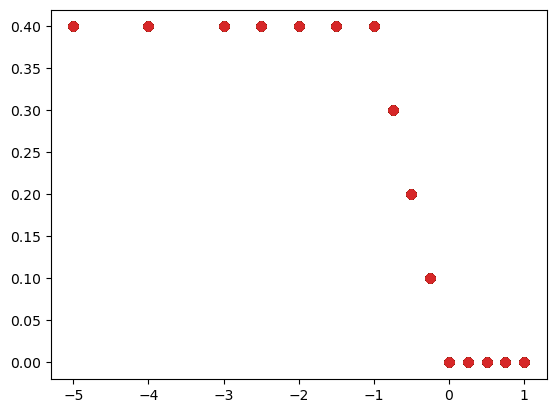

In [547]:
plt.scatter(marcs_st_s_grid['[M/H]'], marcs_st_s_grid['[alpha/Fe]'])
plt.scatter(marcs_st_s_grid['[M/H]'], marcs_st_s_grid['[O/Fe]'])

plt.scatter(marcs_st_p_grid['[M/H]'], marcs_st_p_grid['[alpha/Fe]'])
plt.scatter(marcs_st_p_grid['[M/H]'], marcs_st_p_grid['[O/Fe]'])

In [ ]:
marcs_st_s_grid = pd.read_csv('../')

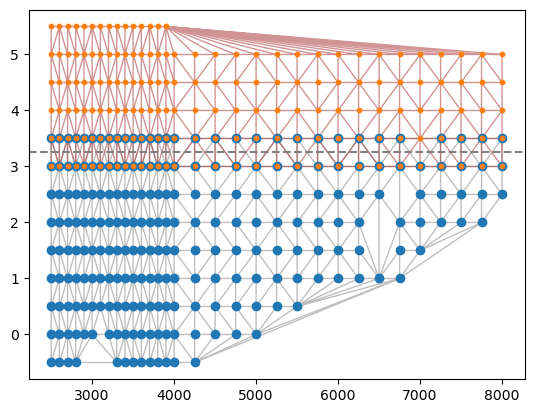

In [557]:
# Plot the Delaunay lines
indices = (marcs_st_s_grid['vmicro'] == 2) & (marcs_st_s_grid['mass'] == 1) & (marcs_st_s_grid['[M/H]'] == 0)
grid_matrix = np.array(marcs_st_s_grid.loc[indices, ['teff', 'logg']])
tri = Delaunay(grid_matrix)
plt.scatter(marcs_st_s_grid.loc[indices, 'teff'], marcs_st_s_grid.loc[indices, 'logg'])
plt.triplot(grid_matrix[:,0], grid_matrix[:,1], tri.simplices, zorder=0, lw=1, color='gray', alpha=0.5)

indices = (marcs_st_p_grid['vmicro'] == 2) & (marcs_st_p_grid['[M/H]'] == 0)
grid_matrix = np.array(marcs_st_p_grid.loc[indices, ['teff', 'logg']])
tri = Delaunay(grid_matrix)
plt.scatter(marcs_st_p_grid.loc[indices, 'teff'], marcs_st_p_grid.loc[indices, 'logg'], s=10)
plt.triplot(grid_matrix[:,0], grid_matrix[:,1], tri.simplices, zorder=0, lw=1, color='brown', alpha=0.5)

plt.axhline(3.25, ls='--', color='gray')

# Tutorial

## Quick start

Let's create a synthetic spectra without caring about all the details:

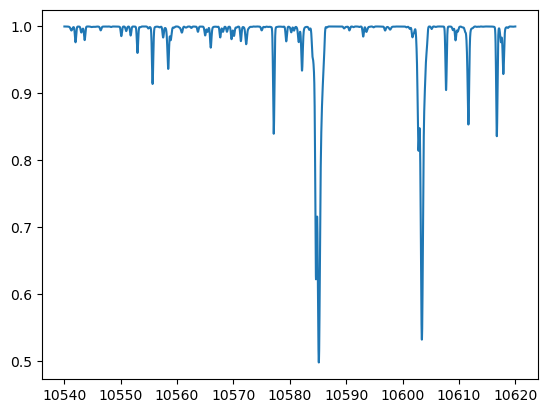

In [11]:
# Basic usage of synth.

#                      Teff, logg, [M/H], start_wavelength, end_wavelength, resolution
s = pymoog.synth.synth(5060,  4.7,     0,            10540,          10620,      50000)
s.prepare_file()
s.run_moog()
s.read_spectra()

# Plot the synthetic spectra
plt.plot(s.wav, s.flux)

## `synth`: creating synthetic spectra

Now let's see what we can control in `synth`, the core part of `pymoog`.

In [18]:
pymoog.synth.synth?

In [16]:
s = pymoog.synth.synth(5060, 4.7, 0, 10540, 10620, 50000, vmicro=2, mass=1, del_wav=0.02, 
                       line_list='vald_3000_24000', weedout=False, prefix='')
s.prepare_file(model_file=None, model_format='moog', loggf_cut=None, abun_change=None, molecules_include=None, 
               atmosphere=1, lines=1, smooth_para=None, model_type='marcs', model_chem='st', model_geo='auto')
s.run_moog(output=False)
s.read_spectra()

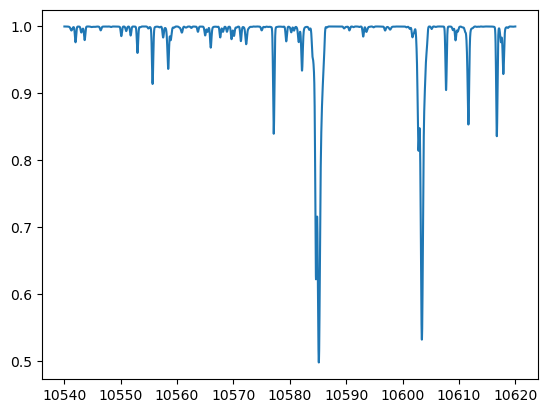

In [17]:
plt.plot(s.wav, s.flux)
# s.read_spectra(remove=False)
# plt.plot(s.wav, s.flux)



For other parameters which is not introduced here, please refer to the comment lines of each function.

After we understand how to use `synth`, the usage of other classese are similar.

## `abfind`

In [22]:
ges_linelist = pymoog.line_data.read_linelist('ges')
ges_linelist = ges_linelist[(ges_linelist['wavelength'] > 8000) & (ges_linelist['wavelength'] < 8100) & (ges_linelist['EW'] > 15)]
ges_linelist = ges_linelist[(ges_linelist['id'] == 26) | (ges_linelist['id'] == 14)]
ges_linelist

,wavelength,id,EP,loggf,C6,D0,EW
85992,8002.576,26.0,4.580,-1.618,-7.79,NaN,22.80
86381,8026.940,14.0,6.261,-1.004,-6.98,NaN,34.24
86400,8027.941,26.0,3.252,-2.785,-7.73,NaN,28.46
86401,8028.313,26.0,4.473,-0.686,-7.54,NaN,76.66
86520,8035.618,14.0,5.984,-1.372,-7.16,NaN,24.95
86696,8046.047,26.0,4.415,-0.100,-7.55,NaN,125.55
86735,8047.617,26.0,0.859,-4.742,-7.85,NaN,50.73
86750,8049.366,14.0,6.269,-1.287,-6.98,NaN,20.15
87069,8071.283,14.0,6.099,-1.192,-7.06,NaN,31.16
87075,8072.164,26.0,2.424,-3.519,-7.82,NaN,32.43


In [3]:
a = pymoog.abfind.abfind(5777, 4.0, 0, line_list=ges_linelist)
a.prepare_file()
a.run_moog()
a.read_output()

## `blends`

In [2]:
ges_linelist = pymoog.line_data.read_linelist('ges')
ges_linelist = ges_linelist[(ges_linelist['wavelength'] > 8000) & (ges_linelist['wavelength'] < 8010)]

In [3]:
w = pymoog.weedout.weedout(5060, 4.7, 0, 8002.576-0.5, 8002.576+0.5, line_list=ges_linelist)
w.prepare_file()
w.run_moog()
w.read_linelist(remove=False)
w.compare(50000)

In [4]:
w.keep_list

,wavelength,id,EP,loggf,C6,D0,EW
0,8002.576,26.0,4.58,-1.618,-7.79,NaN,NaN


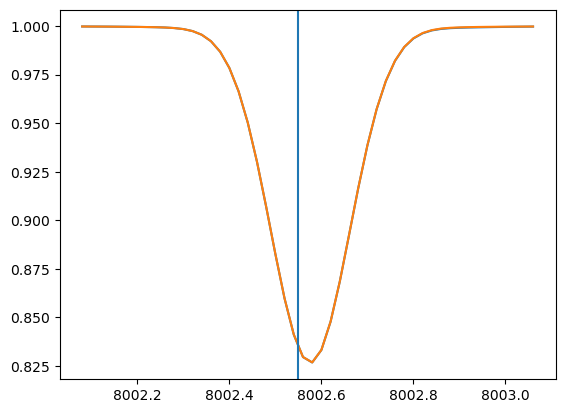

In [5]:
plt.plot(w.wav_all, w.flux_all)
plt.plot(w.wav_keep, w.flux_keep)

plt.axvline(8002.55)

In [7]:
np.sum(1-w.flux_all)*0.02*1000

37.74519999999999

In [19]:
b = pymoog.blends.blends(5777, 4.0, 0, 8002.576-0.5, 8002.576+0.5, 37.74, 26)
b.prepare_file()
b.run_moog(output=True)
b.read_output()

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER blends 
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
SUMMARY ABUNDANCE OUTPUT; here is the filename: MOOG.out2                       
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


In [20]:
b.blends_s_df

,wavelength,ID,EP,logGF,EWin,logRWin,abund,delavg
0,8002.576,26.0,4.58,-1.618,37.74,-5.326,7.689,0.0


## `cog`

In [2]:
vald = pymoog.line_data.read_linelist('vald_winered')

In [3]:
t = vald.loc[1000:1000]
t.loc[1000, 'loggf'] = -3

/tmp/ipykernel_3917791/681715747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.loc[1000, 'loggf'] = -3


In [4]:
c = pymoog.cog.cog(5000, 4, 0, line_list=vald.loc[1000:1000])
c.prepare_file()
c.run_moog()
c.read_output()

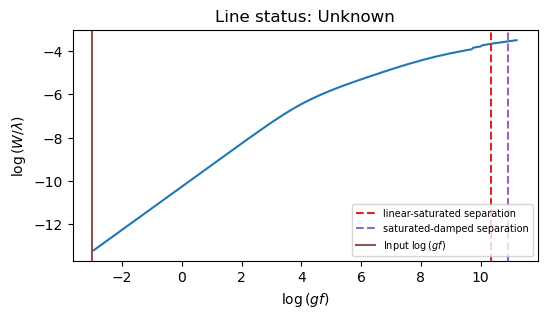

In [5]:
c.get_line_status(plot='cog')

In [7]:
with open('/home/mingjie/.pymoog/cog-05:37:44.366958/MOOG.out2', 'r') as file:
    cog_content = file.readlines()

cog_single_content = [ele.replace(' ', ',').split() for ele in cog_content[6:]]
# cog_single_content = [item for sublist in cog_single_content for item in sublist]
# cog_array = private.np.array(cog_single_content, dtype=float).reshape(-1,2)
# loggf = cog_array[:,0]
# logrw = cog_array[:,1]

In [8]:
cog_single_content

[[',-5.526,-15.795,-5.476,-15.745,-5.426,-15.695,-5.376,-15.645,-5.326,-15.595'],
 [',-5.276,-15.545,-5.226,-15.495,-5.176,-15.445,-5.126,-15.395,-5.076,-15.345'],
 [',-5.026,-15.295,-4.976,-15.245,-4.926,-15.195,-4.876,-15.145,-4.826,-15.095'],
 [',-4.776,-15.045,-4.726,-14.995,-4.676,-14.945,-4.626,-14.895,-4.576,-14.845'],
 [',-4.526,-14.795,-4.476,-14.745,-4.426,-14.695,-4.376,-14.645,-4.326,-14.595'],
 [',-4.276,-14.545,-4.226,-14.495,-4.176,-14.445,-4.126,-14.395,-4.076,-14.345'],
 [',-4.026,-14.295,-3.976,-14.245,-3.926,-14.195,-3.876,-14.145,-3.826,-14.095'],
 [',-3.776,-14.045,-3.726,-13.995,-3.676,-13.945,-3.626,-13.895,-3.576,-13.845'],
 [',-3.526,-13.795,-3.476,-13.745,-3.426,-13.695,-3.376,-13.645,-3.326,-13.595'],
 [',-3.276,-13.545,-3.226,-13.495,-3.176,-13.445,-3.126,-13.395,-3.076,-13.345'],
 [',-3.026,-13.295,-2.976,-13.245,-2.926,-13.195,-2.876,-13.145,-2.826,-13.095'],
 [',-2.776,-13.045,-2.726,-12.995,-2.676,-12.945,-2.626,-12.895,-2.576,-12.845'],
 [',-2.526,-12.7

## `weedout`: remove the weak lines

In [2]:
w = pymoog.weedout.weedout(5000, 2, 0, 10800, 10820)
w.prepare_file(model_type='kurucz')
w.run_moog()
w.read_linelist()
w.compare(50000)
# w.keeplines, w.tosslinesoss

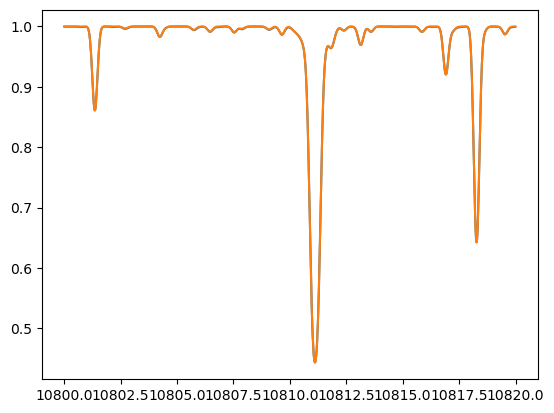

In [4]:
plt.plot(w.wav_all, w.flux_all)
plt.plot(w.wav_keep, w.flux_keep)

## synpop

In [10]:
# Prepare three models 
s = pymoog.synth.synth(5060, 4.7, 0, 10540, 10620, 50000, vmicro=2, mass=1, del_wav=0.02, 
                       line_list='vald_3000_24000', weedout=False, prefix='')
s.prepare_file(model_file=None, model_format='moog', loggf_cut=None, abun_change=None, molecules=None, 
               atmosphere=1, lines=1, smooth_para=None, model_type='marcs', model_chem='st', model_geo='auto')
s.run_moog(output=False)
# s.read_spectra()

In [13]:
path = s.rundir_path

In [16]:
pymoog.model.interpolate_model(7000, 3.8, -0.3, save_name=path+'MODEL3')

## Other functions

There are some funcitons in the package which is not in MOOG, but developed by Mingjie.
Here we will introduce them.

In [22]:
pymoog.line_data.find_single_dominant_line(10818.3, 5000, 4.0, 0, 28000, line_list='vald_3000_24000', weedout_switch=False)

cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot

,wavelength,id,EP,loggf,C6,D0,EW,r_blend_depth
0,10818.274,26.0,3.96,-1.948,-7.82,NaN,NaN,0.004844


cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory
cp: cannot stat 'line.list': No such file or directory


([{'tau_ref': array([1.5196e-05, 2.1379e-05, 3.1124e-05, 4.6488e-05, 7.0764e-05,
          1.0917e-04, 1.6998e-04, 2.6627e-04, 4.1885e-04, 6.6062e-04,
          1.0438e-03, 1.3051e-03, 1.6342e-03, 2.0484e-03, 2.5699e-03,
          3.2266e-03, 4.0533e-03, 5.0940e-03, 6.4038e-03, 8.0531e-03,
          1.0130e-02, 1.2743e-02, 1.6034e-02, 2.0176e-02, 2.5393e-02,
          3.1959e-02, 4.0226e-02, 5.0633e-02, 6.3735e-02, 8.0231e-02,
          1.0099e-01, 1.2713e-01, 1.6004e-01, 2.0146e-01, 2.5359e-01,
          3.1921e-01, 4.0181e-01, 5.0572e-01, 6.3648e-01, 8.0105e-01,
          1.0082e+00, 1.2695e+00, 1.5997e+00, 2.0179e+00, 2.5474e+00,
          3.2183e+00, 4.0646e+00, 5.1227e+00, 6.4455e+00, 8.1031e+00,
          1.0184e+01, 1.6246e+01, 2.5770e+01, 4.0816e+01, 6.4623e+01,
          1.0240e+02]),
   'CF_Ic': array([4.13987081e-10, 6.02904991e-10, 8.95662381e-10, 1.36776305e-09,
          2.15973822e-09, 3.33039526e-09, 5.33023130e-09, 8.60144159e-09,
          1.36375820e-08, 2.17094567e-

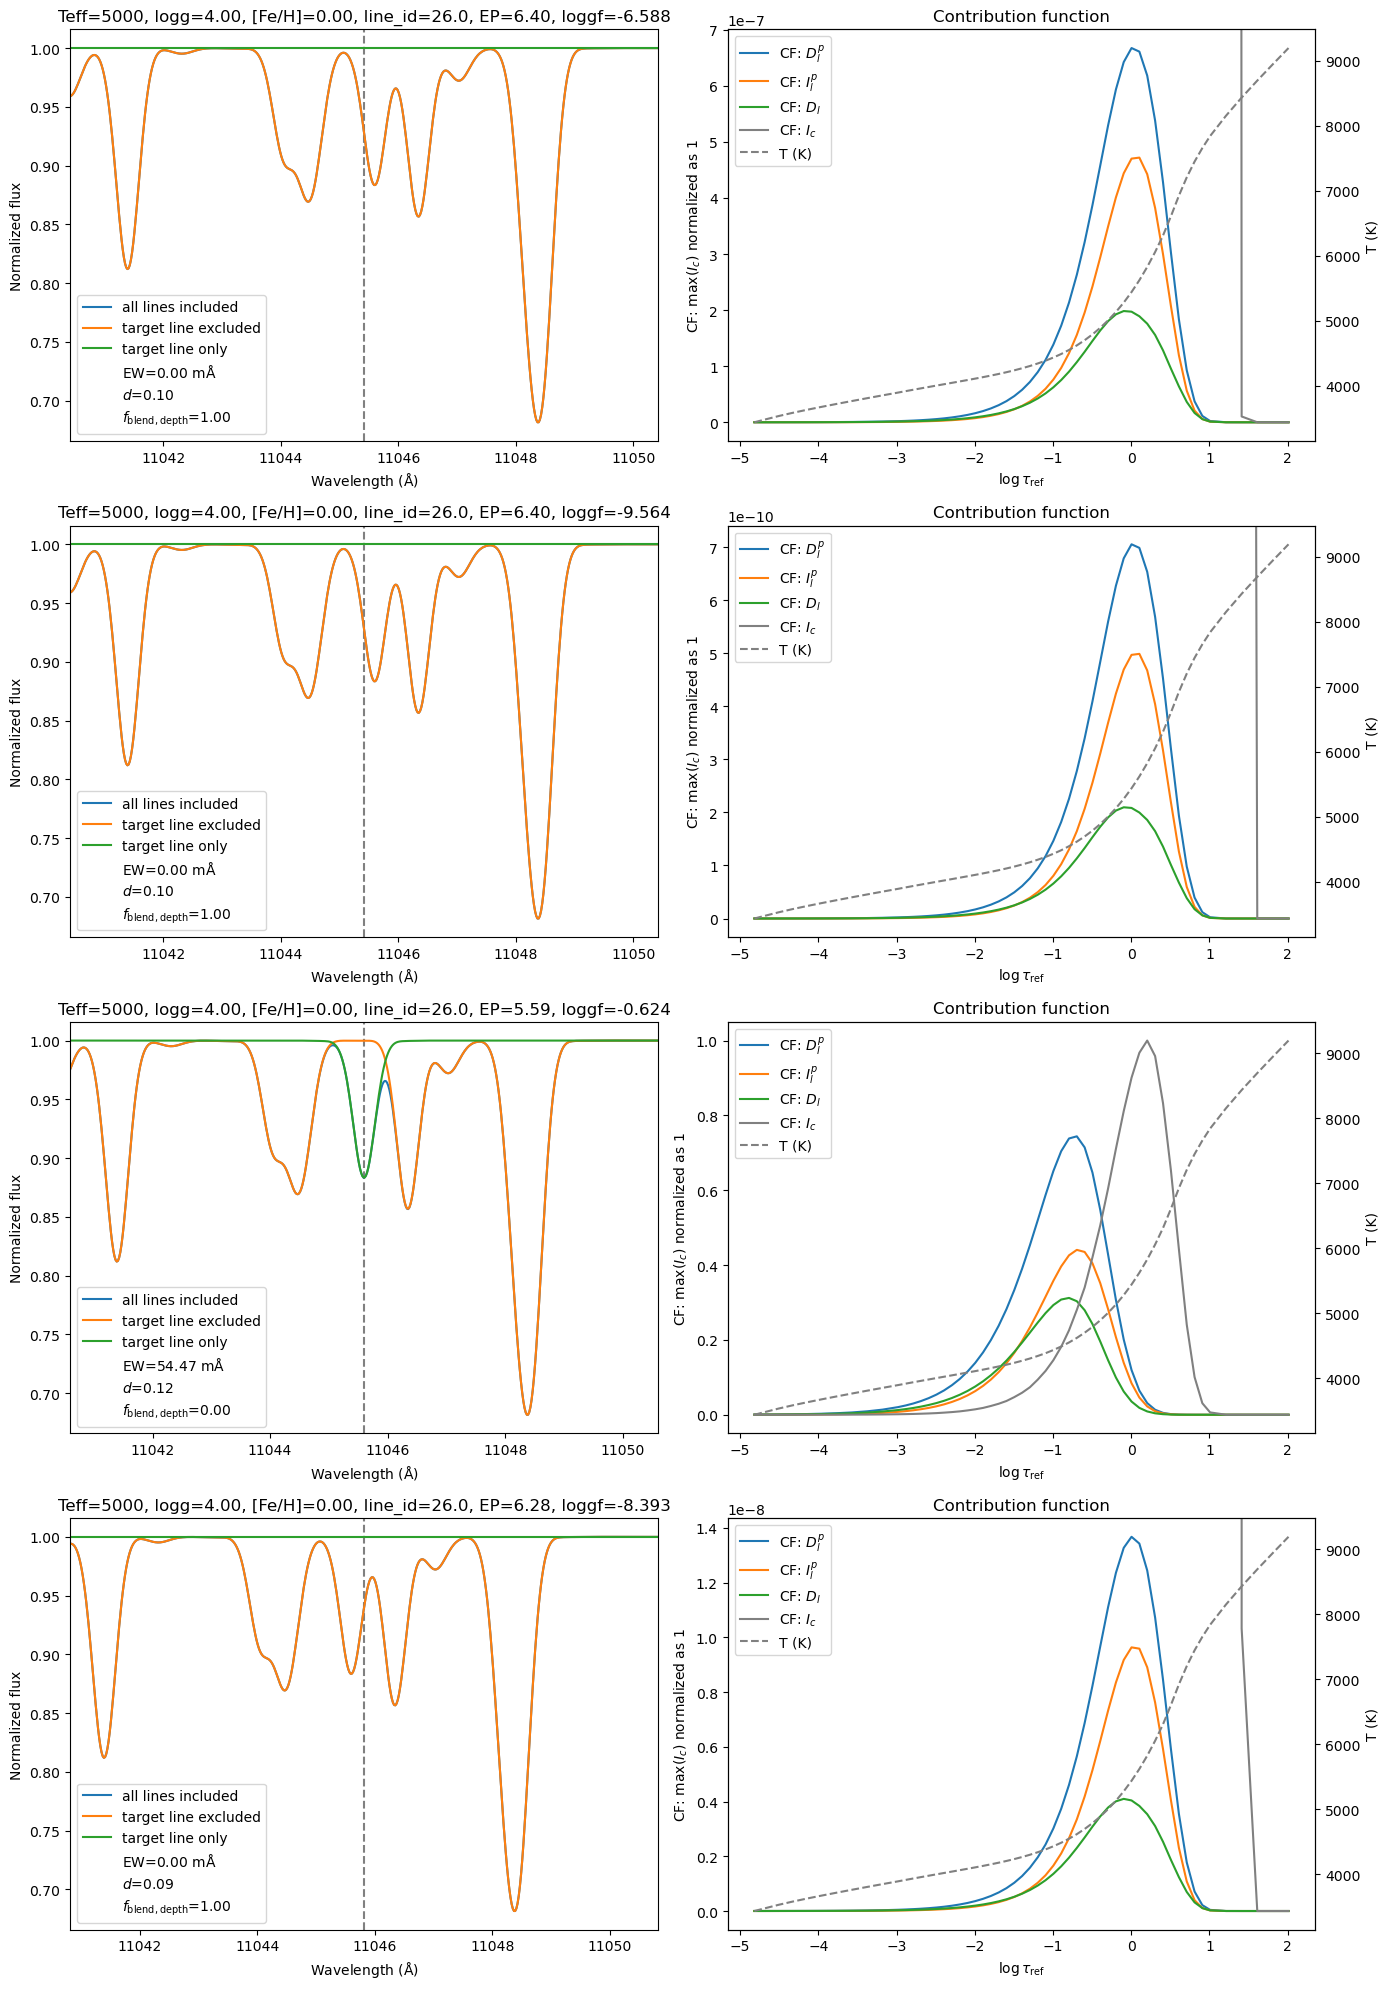

In [7]:
line_wav_input = 11045.599
line_id = 26.0
teff = 5000; logg = 4.0; fe_h = 0 
resolution = 28000
pymoog.contri_func.plot_contri_func(teff, logg, fe_h, resolution, 'vald_3000_24000', line_wav_input=line_wav_input, line_id=line_id)

# Solar case

## MPFIT

In [2]:
def find_isolated_lines(teff, logg, m_h, wav_range_list, ele_index, resolution, obs_spec, line_list_in='vald_3000_24000', x_index_thres=-6, depth_obs_thres=0.05):

    # Only the Fe lines with depth > depth_lower_limit and blending ratio < blending_limit will be selected.
    depth_lower_limit = 0.05
    blending_limit = 0.2

    j = 0
    for wav_range in tqdm(wav_range_list):
    # for wav_range in tqdm(wav_range_list[0:1]):

        wav_start, wav_end = wav_range[0], wav_range[1]

        if isinstance(line_list_in, str):
            # Linelist file is not specified, use internal line list;
            line_list = pymoog.line_data.read_linelist(line_list_in)
        elif isinstance(line_list_in, private.pd.DataFrame):
            line_list = line_list_in
        else:
            raise TypeError('Type of input linelist have to be either str or pandas.DataFrame.')
        
        indices = (line_list['id'] == ele_index) & (line_list['wavelength'] >= wav_start) & (line_list['wavelength'] <= wav_end)
        line_list_ele = line_list[indices].reset_index(drop=True)
    #     pymoog.line_data.save_linelist(line_list_ele, '{}/vald_fe_use.list'.format(folder_name))

        w = pymoog.weedout.weedout(teff, logg, m_h, 
                                   np.min(line_list_ele['wavelength']), np.max(line_list_ele['wavelength']), 
                                   line_list=line_list_ele, kappa_ratio=0.1)
        w.prepare_file()
        w.run_moog()
        w.read_linelist()

        line_list_ele = w.keep_list

        line_list_ele = pymoog.mpfit.cal_depth(line_list_ele, teff, logg, m_h, 2, np.mean(wav_range)/resolution, tqdm_disable=False)
        line_list_ele = line_list_ele[line_list_ele['depth'] > depth_lower_limit].reset_index(drop=True)

        line_list_ele = pymoog.mpfit.cal_depth_blending_ratio(line_list_ele, teff, logg, m_h, 2, np.mean(wav_range)/resolution, tqdm_disable=False)
        line_list_ele = line_list_ele[line_list_ele['f_d_blend'] < blending_limit].reset_index(drop=True)

        if j == 0:
            line_list_ele_all = line_list_ele
        else:
            line_list_ele_all = pd.concat([line_list_ele_all, line_list_ele])
        j += 1

    line_list_ele_all = line_list_ele_all.reset_index(drop=True)

    # TODO: Calculate the tel_blending ratio
    i = 1
    t = []
    obs_depth = []

    obs_spec = pd.read_csv('solar_spec.txt', sep=' ', names=['wav', 'obs_spec'])
    obs_spec['obs_spec'] /= np.median(obs_spec['obs_spec'])

    wavs = line_list_ele_all['wavelength'].values
    for wav in wavs:
        obs_indices = np.abs(obs_spec['wav']-wav) <= 0.2
        obs_depth.append(1 - np.min(obs_spec.loc[obs_indices, 'obs_spec']))
        t.append(wav)

    line_list_ele_all['depth_obs'] = obs_depth

    line_list_ele_all = pymoog.mpfit.cal_X_index(line_list_ele_all, teff)
    line_list_ele_all = line_list_ele_all[line_list_ele_all['X_index'] < x_index_thres].reset_index(drop=True)

    line_list_ele_all = line_list_ele_all[line_list_ele_all['depth_obs'] > depth_obs_thres].reset_index(drop=True)
    
    return line_list_ele_all

In [3]:
solar_spec = pd.read_csv('solar_spec.txt', sep=' ', names=['wav', 'obs_spec'])
solar_spec['obs_spec'] /= np.median(solar_spec['obs_spec'])

line_list_use = find_isolated_lines(5777, 4.0, 0, [[7400, 7500]], 26, 28000, solar_spec)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [23]:
line_list_use

,wavelength,id,EP,loggf,C6,D0,EW,depth,f_d_blend,depth_obs,X_index
0,7421.559,26.0,4.638,-1.800,-7.272,NaN,NaN,0.05581,0.017649,0.141652,-6.505009
1,7430.538,26.0,2.588,-3.860,-7.628,NaN,NaN,0.05012,0.109133,0.123260,-6.485391
2,7435.591,26.0,5.309,-0.716,-7.260,NaN,NaN,0.11881,0.003190,0.199878,-6.101704
3,7443.022,26.0,4.186,-1.820,-7.810,NaN,NaN,0.11616,0.073566,0.292450,-6.066479
4,7461.519,26.0,2.559,-3.580,-7.632,NaN,NaN,0.08994,0.033759,0.229651,-6.175972
5,7464.293,26.0,5.410,-1.066,-7.260,NaN,NaN,0.05547,0.062808,0.083122,-6.554163
6,7472.750,26.0,5.352,-0.994,-7.260,NaN,NaN,0.07021,0.022981,0.097145,-6.423325
7,7473.554,26.0,4.607,-1.870,-7.298,NaN,NaN,0.05189,0.130852,0.130576,-6.543561
8,7476.375,26.0,4.795,-1.680,-7.240,NaN,NaN,0.05280,0.169895,0.136978,-6.544277
9,7494.395,26.0,5.352,-1.119,-7.260,NaN,NaN,0.05584,0.117153,0.110659,-6.548325


In [24]:
line_wav = line_list_use.loc[0, 'wavelength']
del_wav = 20 / 3e5 * line_wav
wav_part = solar_spec.loc[np.abs(solar_spec['wav'] - line_wav) <= del_wav, 'wav'].values
flux_part = solar_spec.loc[np.abs(solar_spec['wav'] - line_wav) <= del_wav, 'obs_spec'].values

In [27]:
pymoog.mpfit.mpfit_main(wav_part, flux_part, 2, 0.4, 0, 0, {}, ['vbroad', 'm_h', 'rv'], 5777, 4.0,
                        fitting_boundary={'m_h':[-0.65, 0.65]})

Reached maximum iteration number, iteration stopped and the mean result of the iteration after 20 is set as final result.


(2,
 0.05,
 0.1432215500600148,
 -0.031294502996545154,
 {},
 0.004437168548095688,
 30,
 {'vmicro': [2],
  'vbroad': [0.4,
   0.22483949500451667,
   0.14259493248587735,
   0.06094182853105476,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05],
  'm_h': [0,
   0.3924538707644987,
   0.0026923940998360707,
   -0.037835227103717006,
   -0.030346001709994155,
   -0.03158184851484224,
   -0.03202139357185437,
   -0.03148790972581236,
   -0.032174505982177255,
   -0.031519731566928354,
   -0.03194383318038463,
   -0.03270705250341699,
   -0.032351451320483435,
   -0.030811815220582607,
   -0.030575160187005263,
   -0.03166511593245951,
   -0.03228035686582785,
   -0.03125310631278813,
   -0.031941188534838634,
   -0.03270446169716267,
   -0.0323488542140868,
   -0.030809219455582945,
   -0.030700102

In [30]:
pymoog.mpfit.mpfit_main(wav_part, flux_part, 1, 0.4, 0, 0, {}, ['vbroad', 'm_h', 'rv'], 5777, 4.0,
                        fitting_boundary={'m_h':[-0.65, 0.65]}, niter_max=10)

In [31]:
vmicro_list = np.linspace(1, 3, 10)

res_all = []
for vmicro in tqdm(vmicro_list):
    res = pymoog.mpfit.mpfit_main(wav_part, flux_part, vmicro, 0.4, 0, 0, {}, ['vbroad', 'm_h', 'rv'], 5777, 4.0,
                        fitting_boundary={'m_h':[-0.65, 0.65]})
    res_all.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: The separation between grid points is too large, failed to interpolate.

In [ ]:
vmicro_list = np.linspace(0.5, 2.5, 20)

vmicro_final_list = []
vmicro_final_err_list = []
m_h_final_list = []
m_h_final_err_list = []

for star_id in tqdm(stock_2_para.index):
# for star_id in [1]:
    star_name = stock_2_para.loc[star_id, 'NAME']
    folder_name = 'mpfit_res_{}'.format(star_name)

    mpfit_res_list = os.listdir(folder_name)
    mpfit_res_list = [i for i in mpfit_res_list if 'mpfit_res_line' in i]

    vald_winered_fe_all = pd.read_csv('{}/vald_fe_use.list'.format(folder_name))

    skip_line = []
    spline_res = {}
    x_index_dict = {}

    plt.figure(figsize=(13, 6), dpi=100)

    ax1 = plt.subplot2grid(shape=(3, 2), loc=(0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((3, 2), (2, 0))
    ax3 = plt.subplot2grid((3, 2), (2, 1), colspan=1)

    j = 1
    for mpfit_res in mpfit_res_list:
        mpfit_res_single = pd.read_csv('{}/{}'.format(folder_name, mpfit_res))
        line = float(mpfit_res[15:-4])

        spline_indices = ~np.isnan(mpfit_res_single['m_h'])

        if len(mpfit_res_single[spline_indices]) <= 10:
            skip_line.append(line)
            continue
        spline = scipy.interpolate.UnivariateSpline(mpfit_res_single.loc[spline_indices, 'vmicro'], 
                                                    mpfit_res_single.loc[spline_indices, 'm_h'], k=3, s=10**-1)

        vmicro_plot = np.arange(0.5, 2.51, 0.01)

        # Remove the line if any of the result is in the boundary
        remove_switch = np.any((mpfit_res_single['m_h'] == -0.65) | (mpfit_res_single['m_h'] == 0.65))
        # Remove the line if any of the slope is larger than 1
        remove_switch = remove_switch or np.any((rulerwd.pandora.calculate_delta(mpfit_res_single['m_h'])/0.10526316 > 1) | (rulerwd.pandora.calculate_delta(mpfit_res_single['m_h'])/0.10526316 < -2))
        # Remove the line if the scatter of spline fitting is larger than 0.15.
        remove_switch = remove_switch or np.nansum(np.abs(spline(vmicro_list) - mpfit_res_single['m_h'])) > 1
    #     # Remove the line if the [Fe/H] result is too small
        remove_switch = remove_switch or (np.any((mpfit_res_single['m_h'] < -0.6)) or np.any((mpfit_res_single['m_h'] > 0.6)))
#         remove_switch = remove_switch or np.any(mpfit_res_single.loc[mpfit_res_single['vmicro']>1.5, 'm_h'] > 0.57)
#         if np.any(mpfit_res_single.loc[mpfit_res_single['vmicro']>1.5, 'm_h'] > 0.57):
#             print('gggg' + str(line))

        if remove_switch:
            skip_line.append(line)
    #         ax1.scatter(mpfit_res_single['vmicro'], mpfit_res_single['m_h'], c='gray', s=4)
    #         ax1.plot(vmicro_plot, spline(vmicro_plot), c='gray', zorder=0, alpha=0.5)
            continue

    #     ax1.scatter(mpfit_res_single['vmicro'], mpfit_res_single['m_h'], c='C0', s=5)
        ax1.plot(vmicro_plot, spline(vmicro_plot), c='C0', alpha=0.6)

        if j == 1:
            record = mpfit_res_single[['vmicro', 'm_h']]
            record.columns = ['vmicro_1', 'm_h_1']
        else:
            record = pd.concat([record, mpfit_res_single[['m_h']]], axis=1)
            record.columns = list(record.columns[:-1]) + ['m_h_{}'.format(j)]
        spline_res[line] = spline

        x_index = vald_winered_fe_all.loc[vald_winered_fe_all['wavelength'] == line, 'X_index'].values[0]
        x_index_dict[line] = x_index
        # Get X index of this line. (TBD)

        j += 1

    ax1.set_xlabel('Vmicro')
    ax1.set_ylabel('[M\H]')
    ax1.set_title('{}, {} lines'.format(star_name, len(vald_winered_fe_all) - len(skip_line)))

    # Boostrap

    vmicro_list_res = []
    m_h_list = []

    bt_num = 1000
    i = 1
    while i <= bt_num:
        selected_indices = (np.random.rand(len(spline_res))*len(spline_res)).astype(int)
        selected_lines = [list(spline_res.keys())[index] for index in selected_indices]

        spline_res_bt = [[k, spline_res[k]] for k in selected_lines]
        x_index_bt = [[k, x_index_dict[k]] for k in selected_lines]
        try:
            vmicro, m_h, _ = determine_vmicro_m_h(spline_res_bt, x_index_bt)
        except:
            continue

        vmicro_list_res.append(vmicro)
        m_h_list.append(m_h)
        i += 1

    ax2.hist(vmicro_list_res, bins=30);
    ax2.axvline(np.median(vmicro_list_res), c='C1')    
    ax2.set_title('{:.2f}$\pm${:.2f}'.format(np.median(vmicro_list_res), np.std(vmicro_list_res)))
    ax2.set_xlabel('Vmicro')

    ax3.hist(m_h_list, bins=30);
    ax3.axvline(np.median(m_h_list), c='C1')    
    ax3.set_title('{:.2f}$\pm${:.2f}'.format(np.median(m_h_list), np.std(m_h_list)))
    ax3.set_xlabel('[M\H]')

    plt.tight_layout()
    plt.savefig('{}/vmicro_result_{}.png'.format(folder_name, star_name), dpi=200)
    plt.close()

    vmicro = np.median(vmicro_list_res)
    vmicro_err = np.std(vmicro_list_res)
    m_h = np.median(m_h_list)
    m_h_err = np.std(m_h_list)
    
    vmicro_final_list.append(vmicro)
    m_h_final_list.append(m_h)
    vmicro_final_err_list.append(vmicro_err)
    m_h_final_err_list.append(m_h_err)
    
    vald_winered_fe_all_final = vald_winered_fe_all.drop([vald_winered_fe_all[vald_winered_fe_all['wavelength'] == line].index[0] for line in skip_line]).reset_index(drop=True)
    vald_winered_fe_all_final.to_csv('{}/vald_fe_use_final.list'.format(folder_name), index=False)
    
stock_2_para_angela['vmicro_mpfit'] = vmicro_final_list
stock_2_para_angela['vmicro_mpfit_err'] = vmicro_final_err_list
stock_2_para_angela['m_h_mpfit'] = m_h_final_list
stock_2_para_angela['m_h_mpfit_err'] = m_h_final_err_list
stock_2_para_angela.to_csv('observed_spectra/GIANO/stock2/stock2_angela_mpfit.csv')